## TP Climate Finance

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp

Importing data

---

In [8]:
df_stock=pd.read_excel("Individual_stock_data.xlsx",sheet_name='stock prices').dropna(axis=1)
df_stock=df_stock.set_index('Date')
df_stock.index=pd.to_datetime(df_stock.index)
df_carbonfootprint=pd.read_excel("Individual_stock_data.xlsx",sheet_name='carbon footprint data')
#names=['NAME','SECTOR','SECTOR_NAME','SCOPE1','SCOPE2','EMISSIONS','MARKET_VALUE','REVENUES','CARBON_FOOTPRINT','INTENSITY'])
df_sp=pd.read_excel('Individual_stock_data.xlsx',sheet_name='SP500')
df_sp=df_sp.set_index('Name')

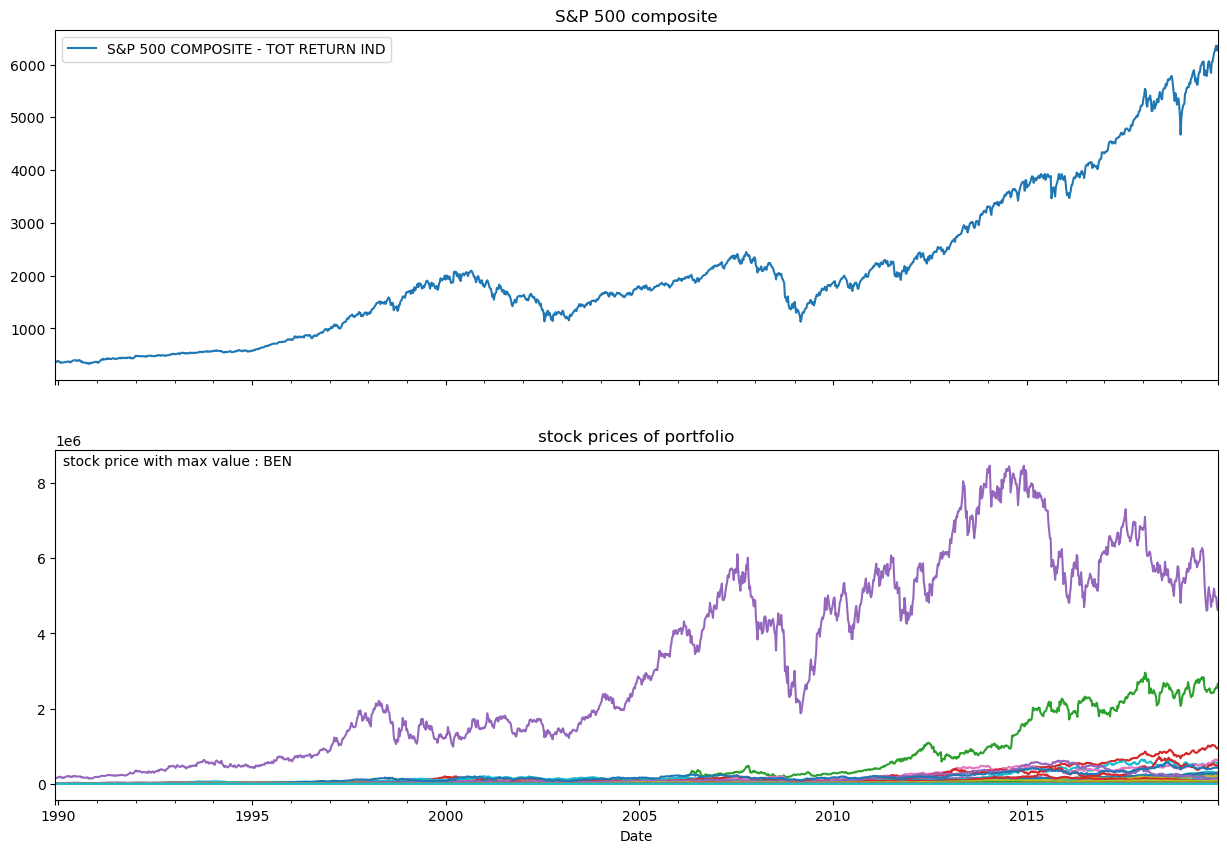

In [44]:
fig,ax=plt.subplots(2,1,figsize=(15,10),sharex=True)
df_sp.plot(ax=ax[0], title='S&P 500 composite')
ax=df_stock.plot(ax=ax[1],legend=False,title='stock prices of portfolio')
ax.text(df_stock.index[10],df_stock.max(axis=0).max(),"stock price with max value : "+f"{df_stock.max(axis=0).idxmax()}")
plt.show()

Weight search by minimizing tracking error

---

In [4]:
def add_return(df):
    iduree=[i for i in range(len(df_stock.index))]
    del iduree[0]        #we exclude the 1st time
    df=df.copy()
    columns=[f'Return {c}' for c in df_stock.columns]
#construction of a dataframe named "dfr" filled with zeros that will contain the values of the returns :
    dfr=pd.DataFrame(np.zeros((len(df.index),len(columns))),columns=columns) 
    for c in df.columns :
#computation of the values of the returns :
        for i in iduree :
            dfr.loc[i,f'Return {c}']=(df.loc[df.index[i],c]-df.loc[df.index[i]-np.timedelta64(7, 'D'),c])/df.loc[df.index[i],c]
#set to zero the values of the returns for the first instant :
        dfr.loc[0,f'Return {c}']=0
    dfr.index=df.index
#Return the concatenation of the initial dataframe "df" and "dfr" which contains the calculated values :
    return pd.concat([df,dfr],axis=1)       

Computation of returns for each corp

In [29]:
df_stock=add_return(df_stock)

Division of the time horizon each 3 years (+ 4 weeks because data begin the 5th december of 1989)

In [30]:
intervalle0=df_stock.index[(df_stock.index < '1993-01-01')]
T=len(intervalle0)
NbT=int(len(df_stock)/T)+1

Dynamic time interval

In [31]:
def Intervalle(i):
    I=df_stock.index[(df_stock.index < '1993-01-01')]
    if i==10:
        I=df_stock.index[(df_stock.index > Intervalle(9).max())]
    if 0<i<NbT:
        I=df_stock.index[(df_stock.index > Intervalle(i-1).max())&(df_stock.index < Intervalle(i-1).max()+np.timedelta64(T+1, 'W'))]
    return I

Optimization

In [45]:
#weights for each corporation
lw=[]
a=0
weights={}
for c in df_stock.columns[int(len(df_stock.columns)/2):]:
    for i in range(NbT):
        model=gp.Model()
        model.Params.LogToConsole = 0
        w=model.addVar(vtype=gp.GRB.CONTINUOUS)
        
        model.setObjective((gp.quicksum(w*df_stock.loc[t,c]-df_sp.loc[t,:] for t in Intervalle(i))**2)/len(Intervalle(i)),gp.GRB.MINIMIZE)
        model.update()
        model.optimize()
        lw.append(w.x)
    weights[c[7:]]=lw[a:]
    a+=10

In [46]:
dfweights=pd.DataFrame(weights)
dfweights.head(10)

,AAPL,MSFT,JPM,JNJ,WMT,BAC,PG,XOM,DIS,T,...,LEG,NWL,JWN,PNR,PBCT,RHI,SEE,FLS,HP,UNM
0,2.552015e+06,5.376945e+04,1.111816e+06,1.291890e+05,7.145995e+04,1.457127e+06,1.395916e+05,1.900922e+05,3.413796e+05,2.256974e+05,...,9.221780e+04,1.335551e+05,0.000000e+00,1.822393e+05,0.000000e+00,0.000000e+00,9.080918e+04,2.106690e+05,0.000000e+00,1.029634e+05
1,0.000000e+00,1.635349e+05,1.757449e+05,1.510752e+05,0.000000e+00,3.246054e+05,2.058132e+05,2.748475e+05,3.103917e+05,1.976131e+05,...,3.161145e+05,5.228792e+05,0.000000e+00,1.608494e+05,8.924085e+04,5.990675e+04,1.269691e+05,4.959647e+05,4.675515e+05,1.645822e+06
2,0.000000e+00,1.136317e+05,2.516552e+05,3.650673e+05,1.437314e+05,3.296587e+05,2.748935e+05,3.688576e+05,5.252003e+05,3.228495e+05,...,4.527986e+05,4.299137e+05,4.507432e+05,6.802865e+05,2.851181e+05,2.741746e+05,6.161683e+05,0.000000e+00,0.000000e+00,5.779998e+05
3,0.000000e+00,0.000000e+00,0.000000e+00,8.483836e+05,3.170320e+06,0.000000e+00,0.000000e+00,1.002526e+06,0.000000e+00,0.000000e+00,...,5.154219e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.970715e+06,0.000000e+00,5.505872e+05,4.405597e+05,0.000000e+00
4,3.001990e+05,0.000000e+00,0.000000e+00,4.299224e+06,0.000000e+00,8.039250e+05,1.102154e+06,1.062947e+06,0.000000e+00,0.000000e+00,...,3.649425e+06,0.000000e+00,3.663371e+05,4.389332e+05,2.387196e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.763201e+06,0.000000e+00
5,2.380388e+05,7.937280e+06,2.030726e+06,1.318221e+07,1.868419e+06,0.000000e+00,1.588952e+06,8.059955e+05,1.513149e+06,5.898072e+05,...,0.000000e+00,0.000000e+00,2.406651e+06,0.000000e+00,1.521108e+06,0.000000e+00,0.000000e+00,2.340109e+05,3.367808e+05,1.162889e+06
6,7.119527e+05,0.000000e+00,0.000000e+00,4.323116e+06,0.000000e+00,0.000000e+00,1.293172e+07,0.000000e+00,4.181282e+06,0.000000e+00,...,1.303593e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,7.627472e+05,8.410763e+05,1.554944e+06,9.478377e+05,1.221844e+06,8.343473e+06,1.531350e+06,1.993779e+06,5.819802e+05,1.798097e+06,...,1.339982e+06,6.406608e+05,1.335539e+06,1.108478e+06,2.818839e+06,8.158456e+05,1.653800e+06,7.309854e+05,1.591681e+06,1.582829e+06
8,1.269434e+06,1.215451e+06,1.341163e+06,1.983470e+06,5.092787e+06,1.739599e+06,2.915356e+06,0.000000e+00,4.312003e+06,3.705195e+06,...,1.881555e+06,1.849667e+06,0.000000e+00,0.000000e+00,3.155630e+06,0.000000e+00,2.518313e+06,0.000000e+00,0.000000e+00,2.115180e+06
9,1.416364e+06,9.126289e+05,1.542144e+06,6.464311e+06,1.578898e+06,1.903501e+06,1.960466e+06,0.000000e+00,1.850420e+06,5.922627e+06,...,5.410717e+06,0.000000e+00,0.000000e+00,9.500649e+06,1.250128e+07,2.476584e+06,0.000000e+00,5.131953e+06,0.000000e+00,0.000000e+00


Text(0.5, 0, "Time interval's number")

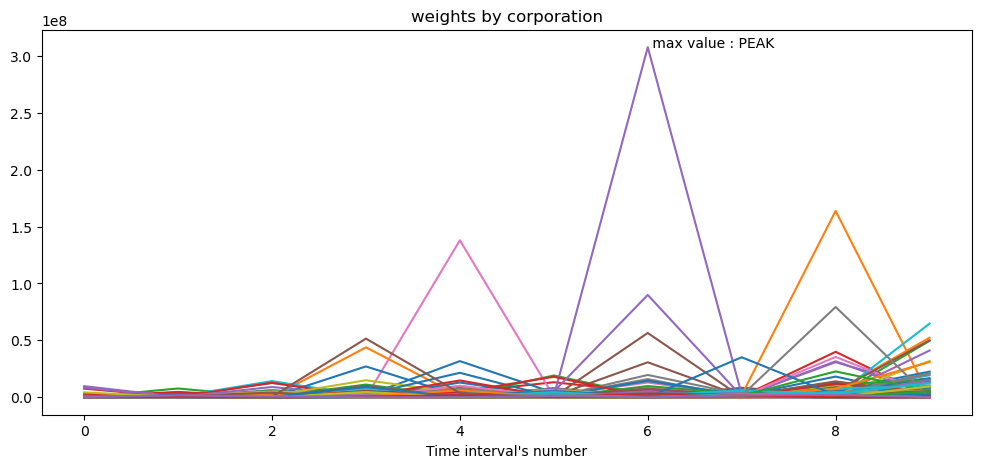

In [47]:
ax=dfweights.plot(legend=False,title='weights by corporation',figsize=(12,5))
ax.text(6,dfweights.max(axis=0).max()," max value : "+f"{dfweights.max(axis=0).idxmax()}")
ax.set_xlabel("Time interval's number")